In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import plotly.express as px
from random import sample
import sklearn.cluster
from sklearn.cluster import KMeans
import sklearn.manifold
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
import json
import os

main_dir = os.path.dirname(os.getcwd())
pyktok_dir = f'{main_dir}/pyktok-results'

In [82]:

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#Going into results file and appending the suggested words for each video to a list, 2 functions for csv and json
def getsuggested_wordsfromcsv(filename):
    sugg_words = []
    file = f'{pyktok_dir}/{filename}'
    print(f'Getting pyktok data from file {file}')
    metadata = pd.read_csv(file)
    for index, row in metadata.iterrows(): #iterating through videos and extracting suggested words
        if row['suggested_words']:
            sugg_words += str(row['suggested_words']).split(',')
    return sugg_words

def getsuggested_wordsfromjson(filename):
    sugg_words = []
    file = f'{filename}'
    print(f'Getting pyktok data from file {file}')
    metadatadict = json.loads(json.load(open(filename)))
    for video in metadatadict['data']:
        sugg_words += video[3]
    return sugg_words





In [26]:
#defining elbow method to identify best number of clusters
def elbowMethod(embeddings, maxK):
    """
    Implements the Elbow method for finding most optimal k.
    It keeps track of a measure named "inertia" for each cluster.
    """
    sumSquaredDistances = []
    kValues = list(range(1, maxK))
    for k in kValues:
        km = KMeans(n_clusters=k, random_state=42)
        km = km.fit(embeddings)
        sumSquaredDistances.append(km.inertia_)
    
    # plot the line to identify the elbow
    plt.plot(kValues, sumSquaredDistances, 'ro-')
    plt.xlabel('k')
    plt.xticks(kValues)
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [39]:
#calling the kmeans method on given embeddings and words lists
def callKmeans(k,embeddedlst,wordlst):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(embeddedlst)
    clusters[:10]

    for i in range(k):
        print(f"Cluster {i}:")
        cluster_words = [wordlst[j] for j in range(len(wordlst)) if clusters[j] == i]
        print(cluster_words)

In [119]:
#to make t-SNE graph readable, 200 words chosen from each user to have a total of 600 words to cluster, take random sample of words
fullwords10824 = getsuggested_wordsfromcsv('results_10824_full.csv')
fullwords12345 = (getsuggested_wordsfromcsv('results_12345_full.csv'))
fullwords50405 = (getsuggested_wordsfromcsv('results_50405_full.csv'))
print(len(fullwords10824+fullwords12345+fullwords50405))#seeing how many total suggested words there are
                                        

suggwords10824 = sample(fullwords10824,200)
suggwords12345 = sample(fullwords12345,200)
suggwords50405 = sample(fullwords50405,200)
#print(suggwords10824)
print(len(suggwords10824))
fullsuggwords = suggwords10824+suggwords12345+suggwords50405 #concatenate all suggested words into one list
print(len(fullsuggwords))

embedded = embed(fullsuggwords) #embed words
embedded.shape

Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/pyktok-results/results_10824_full.csv
Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/pyktok-results/results_12345_full.csv
Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/pyktok-results/results_50405_full.csv
269126
200
600


TensorShape([600, 512])

In [106]:
callKmeans(15,embedded,fullsuggwords) #try with 15 clusters to test elbow method

Cluster 0:
[' orange hair video', ' Black Hair Products', ' emdr therapy black girls', ' DIY Hair', ' black hair', ' What Is A Beauty Supply Store', ' tymo brush on 4c hair', ' Manic Panic', ' hair growth', ' Care Of Hair', ' brunette filter', 'hair care', ' haircare', ' ribbons in hair', ' frizzy hair']
Cluster 1:
['Couples Comedy', ' welding prank on dad', ' run bts dance', ' twilight car scene', ' freestyle rap battle', ' farts spray candle for prank', ' Sung Kang American Actor', ' African Comedy', ' Comedy Video', ' 3 black guys dancing together original', ' shalippopi and zerry dance', ' dwight snowman prank', 'snl', ' david holmes paralyzed scene', ' hunger games whistle', 'rent vs income debunked', ' Standup Comedy Show', ' timothee chalamet snl', ' marcello hernandez snl skit', ' what would you do tv show', ' balloon lagoon game', ' imaginary trailer', ' Mean Girls', 'film school', ' sleeper agent hans frozen', 'coriolanus snow inner monologue', ' hannibal funny moments', ' ho

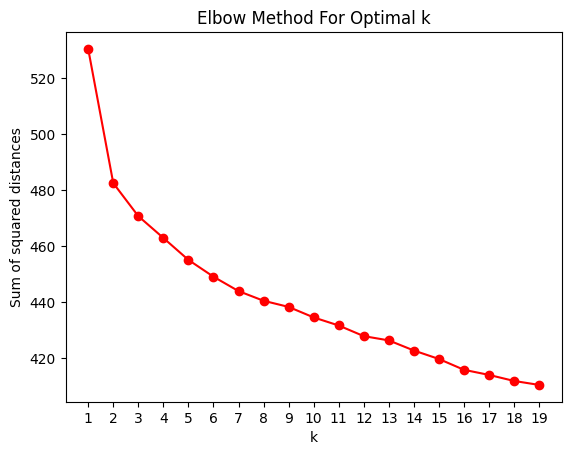

In [107]:
elbowMethod(embedded, 20)


In [108]:
k = 3 #identified from elbow graph
kmeans = KMeans(n_clusters=k, random_state=42) #recluster with 3 clusters
clusters = kmeans.fit_predict(embedded)
Counter(clusters)

Counter({0: 305, 2: 240, 1: 55})

In [109]:
import plotly.io as pio
#plotting tSNE graph
tsne = TSNE(n_components=2, random_state=42)  
tsne_results = tsne.fit_transform(embedded)

df = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
df['hashtag'] = fullsuggwords
df['cluster'] = clusters # the cluster indices where each news hashtags belong
#df.head()

# Create the scatter plot
fig = px.scatter(df, x='tsne_1', y='tsne_2', text='hashtag', color="cluster", color_continuous_scale="BlueRed")

# Format what to show next to the markers
fig.update_traces(textposition='top center', 
                  mode='markers+text', 
                  textfont=dict(size=6))

fig.update_layout(title='Embeddings of TikTok News Hashtags', width=800, height=800)
fig.show()


Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/analysis/filter_data/videos-newsHashtags-10824_full.json
Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/analysis/filter_data/videos-newsHashtags-12345.json
Getting pyktok data from file /Users/adelle/CS315_Project2_Group1/analysis/filter_data/videos-newsHashtags-50405.json
6847
Cluster 0:
['woofyeah', 'assinie', 'foryourpage', 'truecrimetikok', 'newsupdate', 'mrterrifying', 'antycecebars', 'enkyboys', 'burnaboy', 'dogtok', 'crimestories', 'nigeriantiktok🇳🇬', 'southafricatiktok🇿🇦', 'systemicracism', 'longvideos', 'nicholasrossi', 'crimestories', 'coutroom', 'jailtok', 'crimedocumentaries', 'kwadwosheldonstudios', 'breakingnews', 'gypsyroseblancharde', 'kojorae', 'cotedivoire🇨🇮', 'unsolvedmysteries', 'afcon2024', 'lakenriley', 'nigeriantiktok🇳🇬', 'newsfails', 'stephenking', 'ussenate', 'fypage', 'barackobama', 'gretagerwig', 'royalfamily', 'edwinbooth', "alabama's", 'cuteworkoutclothes', 'theythempronoun

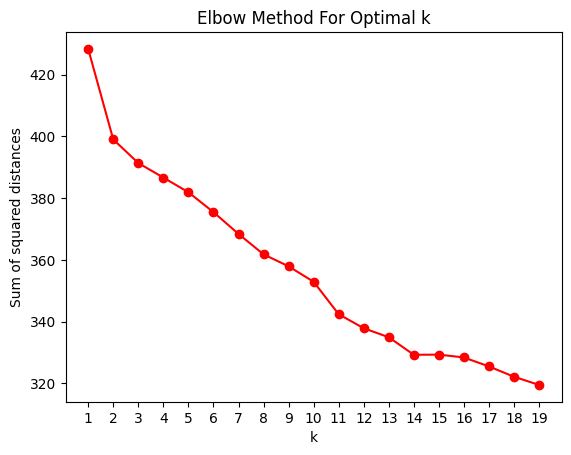

In [120]:
#doing same thing as above but with filtered data
fullnewswords10824 = getsuggested_wordsfromjson('/Users/adelle/CS315_Project2_Group1/analysis/filter_data/videos-newsHashtags-10824_full.json')
fullnewswords12345 = getsuggested_wordsfromjson('/Users/adelle/CS315_Project2_Group1/analysis/filter_data/videos-newsHashtags-12345.json')
fullnewswords50405 = getsuggested_wordsfromjson('/Users/adelle/CS315_Project2_Group1/analysis/filter_data/videos-newsHashtags-50405.json')
print(len(fullnewswords10824+fullnewswords12345+fullnewswords50405)) #seeing how many total news suggested words there are

newswords10824 = sample(fullnewswords10824,200)
newswords12345 = sample(fullnewswords12345,200)
newswords50405 = sample(fullnewswords50405,200)
#newswords10824
fullnewswords = newswords10824+newswords12345+newswords50405

embednews = embed(fullnewswords)

callKmeans(15,embednews,fullnewswords) #try with 15 clusters

elbowMethod(embednews, 20) 


In [117]:
k = 5 #identified as best with elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
clustersN = kmeans.fit_predict(embednews)
Counter(clusters)

Counter({0: 305, 2: 240, 1: 55})

In [118]:
#plotting tSNE graph for filtered data words
tsneN = TSNE(n_components=2, random_state=42)  
tsne_resultsN = tsneN.fit_transform(embednews)

dfN = pd.DataFrame(tsne_resultsN, columns=['tsne_1', 'tsne_2'])
dfN['hashtag'] = fullnewswords
dfN['cluster'] = clustersN # the cluster indices where each news hashtags belong
#df.head()

# Create the scatter plot
fig = px.scatter(dfN, x='tsne_1', y='tsne_2', text='hashtag', color="cluster", color_continuous_scale="BlueRed")

# Format what to show next to the markers
fig.update_traces(textposition='top center', 
                  mode='markers+text', 
                  textfont=dict(size=6))

fig.update_layout(title='Embeddings of TikTok News Hashtags', width=800, height=800)
fig.show()